In [1]:
import torch
import XAI_core
import datasets
import models
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() != -1 else "cpu")


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
model = models.get_model("vgg16", cuda = device == torch.device("cuda:0"))
dataset = datasets.ImageNetSubset(root = "C:\\ImageNet")
loader = datasets.get_data_loader(dataset, batch_size = 3, shuffle = False)
explainer = XAI_core.ConceptExplainer(model, *dataset.mean_std())


In [4]:
layer = model._modules["features"][28]
layer

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [29]:
it = iter(loader)
x, y = next(it)
x.shape

torch.Size([3, 3, 224, 224])

tensor([65])


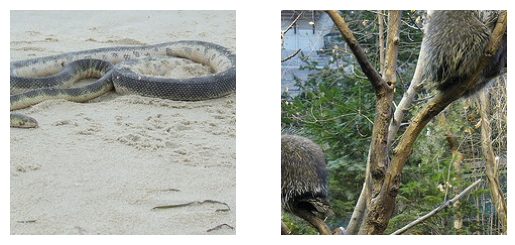

In [25]:
x,y = dataset[0]

y = torch.tensor([y]).long()
x_hat, y_hat = dataset[20]
print(y)

x = x[None,:]
x_viz = dataset.prep_for_viz(x)
x_hat = x_hat[None, :]
x_hat_viz = dataset.prep_for_viz(x_hat)


fig, axs = plt.subplots(1,2)

for ax in axs: ax.axis("off")
axs[0].imshow(x_viz[0])
axs[1].imshow(x_hat_viz[0])

In [30]:
from zennit.image import imgify, imsave

gamma = 1000



prediction = tensor([ 62, 795, 230], device='cuda:0')
tensor(3.0000)


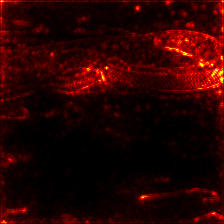

In [32]:
composite_args = dict(epsilon = 1e-6, gamma = gamma)
explainer = XAI_core.ConceptExplainer(model, *dataset.mean_std(), composite_args = composite_args)

out, grad, interm_info = explainer.explain(x.to(device), target_logits = y.long(), layer = layer)

# out, grad, interm_info = explainer.explain(x.to(device), target_logits = torch.tensor([y]).long(), layer = layer)
print(f"prediction = {out.argmax(axis = 1)}")
grad = grad.sum(axis = 1).cpu()
print(grad.sum())
imgify(grad[0], symmetric = True, cmap='coldnhot')

torch.return_types.topk(
values=tensor([[0.1790, 0.1531, 0.0722, 0.0703, 0.0664, 0.0657, 0.0628, 0.0564, 0.0539,
         0.0501],
        [0.2418, 0.2268, 0.1718, 0.1600, 0.1030, 0.0979, 0.0973, 0.0672, 0.0634,
         0.0549],
        [0.5192, 0.4878, 0.3443, 0.2353, 0.2284, 0.1328, 0.1247, 0.1172, 0.1133,
         0.0906]], device='cuda:0'),
indices=tensor([[ 79, 368, 267, 413, 249, 388, 222, 117, 479, 199],
        [151,   1,  18, 277, 414, 125,  75, 357, 284,  53],
        [442, 455, 157, 146, 446, 410, 206, 117, 431,  16]], device='cuda:0'))
tensor(0.1790, device='cuda:0')


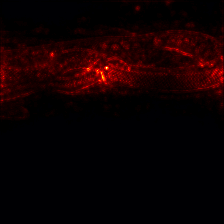

In [35]:
grad_layer = interm_info["intermediate_rel"]
print(grad_layer.topk(10))

grad = explainer.explain_channel(interm_info, 368, retain_graph = True)
print(grad[0].sum())

grad = grad.sum(axis = 1).cpu()
imgify(grad[0], symmetric = True, cmap='coldnhot')